In [ ]:
import numpy as np
import random
import copy
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
class SVM:

  def __init__(self, X_train, y_train, X_test, y_test, val=True, val_type='k_fold', val_distribution='balanced', k=5, learning_rate=0.001, lambda_param=0.01, n_iters=1000):

    self.lr = learning_rate
    self.lambda_param = lambda_param
    self.n_iters = n_iters

    self.X_train = X_train
    self.y_train = y_train

    self.X_test = X_test
    self.y_test = y_test

    self.val_distribution = val_distribution
    self.val = val
    self.val_type=val_type
    self.val_distribution=val_distribution
    self.k=k

    self.w = np.array([])
    self.b = None


  def Gradient_update(self, X_train, y_train, X_val=None, y_val=None):

    n_samples, n_features = X_train.shape  
    y_ = np.where(y_train <= 0, -1, 1)
          
    if self.w.size == 0 and self.b is None :
      self.w = np.zeros(n_features)
      self.b = 0

    w_best = np.zeros(n_features)
    b_best = 0

    acc_list = [] 
    for i in range(0,self.n_iters):
      for idx, x_i in enumerate(X_train):
        condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
        if condition:
          self.w -= self.lr * (2 * self.lambda_param * self.w)
        else:
          self.w -= self.lr * (2 * self.lambda_param * self.w - np.dot(x_i, y_[idx]))
          self.b -= self.lr * y_[idx]

      if i%10 == 0 and self.val:
        approx_w = np.dot(X_val, self.w) - self.b
        approx_w = np.sign(approx_w)
        res_w = np.where(approx_w<0, 0, approx_w)

        approx_w_best = np.dot(X_val, w_best) - b_best
        approx_w_best = np.sign(approx_w_best)
        res_w_best = np.where(approx_w_best<0, 0, approx_w_best)
          
        if (accuracy_score(y_val, res_w_best) - 0.3 < accuracy_score(y_val, res_w)):
          w_best = copy.deepcopy(self.w)
          b_best = copy.deepcopy(self.b)
        else:  
          self.w = copy.deepcopy(w_best)
          self.b = copy.deepcopy(b_best)  
          break

  def Cross_validation(self, val_split):

    if (self.val_distribution == 'balanced'):
      X_train0, X_val0, y_train0, y_val0 = train_test_split(self.X_train[0], self.y_train[0], test_size=val_split)
      X_train1, X_val1, y_train1, y_val1 = train_test_split(self.X_train[1], self.y_train[1], test_size=val_split)

      X_train = np.concatenate((X_train0,X_train1),axis=0)
      y_train = np.concatenate((y_train0,y_train1),axis=0)

      X_val = np.concatenate((X_val0,X_val1),axis=0)
      y_val = np.concatenate((y_val0,y_val1),axis=0)

    elif (self.val_distribution == 'unbalanced'):
      X_train = np.concatenate((self.X_train[0],self.X_train[1]),axis=0)
      y_train = np.concatenate((self.y_train[0],self.y_train[1]),axis=0)

      X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_split)

    X_train, y_train = self.random_shuffle(X_train, y_train)
    self.Gradient_update(X_train, y_train, X_val, y_val)

  def k_fold_cross_validation(self):

    if (self.val_distribution == 'unbalanced'):
      X_train = np.concatenate((self.X_train[0],self.X_train[1]),axis=0)
      y_train = np.concatenate((self.y_train[0],self.y_train[1]),axis=0)

      X_train_, X_train0, y_train_, y_train0 = train_test_split(X_train, y_train, test_size=round(1/self.k,2), shuffle=True)

      X_train = []
      y_train = []

      X_train.append(copy.deepcopy(X_train0))
      y_train.append(copy.deepcopy(y_train0))
      k = self.k - 1

      X_train0 = np.array_split(X_train_,k)
      y_train0 = np.array_split(y_train_,k)

      for i in range(k):
        X_train.append(X_train0[i])
        y_train.append(y_train0[i])

    elif (self.val_distribution == 'balanced'):
      X_train0 = np.array_split(self.X_train[0],self.k)
      X_train1 = np.array_split(self.X_train[1],self.k)
      y_train0 = np.array_split(self.y_train[0],self.k)
      y_train1 = np.array_split(self.y_train[1],self.k)
      X_train = []
      y_train = []
      for i in range(self.k):
        X_train.append(np.concatenate((X_train0[i],X_train1[i]),axis=0))
        y_train.append(np.concatenate((y_train0[i],y_train1[i]),axis=0))

    if self.w.size == 0 and self.b == None:
      w = np.zeros(self.X_train[0].shape[1])
      b = 0
    else:
      w = self.w
      b = self.b

    w_list = []
    b_list = []
    acc_list = []
    for i in range(self.k):
      X_train_temp = np.zeros((1,X_train[0].shape[1]))
      y_train_temp = np.array([])

      for j in range(self.k):
        if (j!=i):
          X_train_temp = np.concatenate((X_train_temp,X_train[j]),axis=0)
          y_train_temp = np.concatenate((y_train_temp,y_train[j]),axis=0)
        else:
          X_val = X_train[j]
          y_val = y_train[j]


      X_train_temp = np.delete(X_train_temp,0,0)
      X_train_temp, y_train_temp = self.random_shuffle(X_train_temp, y_train_temp)
      self.Gradient_update(X_train_temp, y_train_temp, X_val, y_val)
      print(self.accuracy())
      w_list.append(self.w)
      b_list.append(self.b)

      test_w = np.dot(X_val, self.w) - self.b
      test_w = np.sign(test_w)
      res_val = np.where(test_w<0,0,test_w)

      acc_list.append(accuracy_score(y_val, res_val))
    
      self.w = w
      self.b = b

    self.w = w_list[acc_list.index(max(acc_list))]  
    self.b = b_list[acc_list.index(max(acc_list))]
  

  def fit(self):
    if self.val_type == 'k_fold' and self.val:
      self.k_fold_cross_validation()
    
    elif self.val_type == 'cross_val' and self.val:
      self.Cross_validation(0.2)
    
    elif not self.val:
      X_train = np.concatenate((self.X_train[0],self.X_train[1]),axis=0)
      y_train = np.concatenate((self.y_train[0],self.y_train[1]),axis=0)
      X_train, y_train = self.random_shuffle(X_train, y_train)
      self.Gradient_update(X_train, y_train)

  def random_shuffle(self, X_train, y_train):
    self.x_tr, self.x_te, self.y_tr, self.y_te = train_test_split(X_train,y_train,test_size=0.5)
    return np.concatenate((self.x_tr, self.x_te),axis=0), np.concatenate((self.y_tr, self.y_te),axis=0)

  def predict(self):
     approx = np.dot(self.X_test, self.w) - self.b
     approx = np.sign(approx)
     return np.where(approx<0, 0, approx)

  def accuracy(self):
    return accuracy_score(self.y_test, self.predict())*100


In [ ]:
class Federated_SVM:

  def __init__(self, n_clients=4, val=True, val_type='k_fold', val_distribution='balanced', k=5, learning_rate=0.001, lambda_param=0.01, n_iters=100):
    self.n_clients = n_clients
    self.learning_rate = learning_rate
    self.lambda_param = lambda_param
    self.n_iters = n_iters
    self.val = val
    self.val_type = val_type
    self.val_distribution = val_distribution
    self.client_distribution = []
    self.k = k
    self.X_test = None
    self.y_test = None
    
  def create_clients(self, X_train, y_train, X_test, y_test):
    self.clients=[]
    for i in range(self.n_clients):
      self.client_distribution.append(X_train[i][0].shape[0] + X_train[i][1].shape[0])
      self.clients.append(SVM(X_train[i],y_train[i], X_test, y_test, self.val, self.val_type, self.val_distribution, self.k, self.learning_rate, self.lambda_param, self.n_iters))
    self.X_test = copy.deepcopy(X_test)
    self.y_test = copy.deepcopy(y_test)
  

  def average_aggregator(self, parameter_list):
    w = np.zeros(parameter_list[0].shape[0])
    b = 0
    for i in range(0,2*self.n_clients,2):
        w = np.add(w,parameter_list[i]*self.client_distribution[i//2]/sum(self.client_distribution))
    b = b + parameter_list[i+1]
    return (w, b/self.n_clients)

  def fit(self, g_iters, aggregator):
    for i in range(0,g_iters):
      print('global round',i+1)
      for j in range(0,self.n_clients):
        if i==0:
          self.clients[j].fit()
        else:
          self.clients[j].w = w_agg
          self.clients[j].b = b_agg
          self.clients[j].fit()
        print('client',j+1,self.clients[j].accuracy())          
      parameter_list = []
      for k in range(0,self.n_clients):
        parameter_list.append(self.clients[k].w)
        parameter_list.append(self.clients[k].b)
      w_agg, b_agg = aggregator(parameter_list)
      print('global test acc',self.accuracy(w_agg,b_agg))

  def predict(self,w,b):
     approx = np.dot(self.X_test, w) - b
     approx = np.sign(approx)
     return np.where(approx<0, 0, 1)
  
  def accuracy(self,w,b):
    return accuracy_score(self.y_test, self.predict(w,b))*100


In [ ]:
def create_kmeans_clusters(X, Y, n_clusters = 3, random_state = 0):
  clusters = KMeans(n_clusters=n_clusters, random_state=random_state).fit_predict(X)
  result = []
  for i in range(n_clusters):
    result.append(X[clusters == i])
    result.append(Y[clusters == i])
  return tuple(result)  

In [ ]:
def load_mnist_return_required_digits(n1, n2):
  # Loading the mnist dataset and concatenating train - test sets
  (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
  x_total = np.concatenate((x_train, x_test), axis=0)
  y_total = np.concatenate((y_train, y_test), axis=0)

  # Normalizing and reshaping the data
  x_total = x_total/255 
  x_total = x_total.reshape(x_total.shape[0],784)

  x_n1 = x_total[y_total == n1]
  y_n1 = y_total[y_total == n1]

  x_n2 = x_total[y_total == n2]
  y_n2 = y_total[y_total == n2]

  return [(x_n1, y_n1),(x_n2, y_n2)]

# Digits 0 and 6

### Loading the data of 0 and 6

In [ ]:
data = load_mnist_return_required_digits(0, 6)

### Dividing the data of digits 0 and 6 into clusters using the KMeans algorithm
The images of 0 and 6 are divided into 3 three clusters each.

Text(0.5, 1.0, 'Cluster 3')

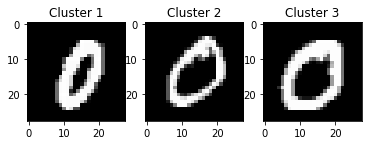

In [ ]:
x_0_c1, y_0_c1, x_0_c2, y_0_c2, x_0_c3, y_0_c3 = create_kmeans_clusters(data[0][0], data[0][1])
fig, axs = plt.subplots(1, 3)
axs[0].imshow(x_0_c1[0].reshape(28,28),cmap='gray')
axs[0].set_title('Cluster 1')
axs[1].imshow(x_0_c2[0].reshape(28,28),cmap='gray')
axs[1].set_title('Cluster 2')
axs[2].imshow(x_0_c3[0].reshape(28,28),cmap='gray')
axs[2].set_title('Cluster 3')

Text(0.5, 1.0, 'Cluster 3')

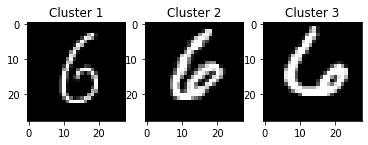

In [ ]:
x_6_c1, y_6_c1, x_6_c2, y_6_c2, x_6_c3, y_6_c3 = create_kmeans_clusters(data[1][0], data[1][1])
fig, axs = plt.subplots(1, 3)
axs[0].imshow(x_6_c1[0].reshape(28,28),cmap='gray')
axs[0].set_title('Cluster 1')
axs[1].imshow(x_6_c2[0].reshape(28,28),cmap='gray')
axs[1].set_title('Cluster 2')
axs[2].imshow(x_6_c3[0].reshape(28,28),cmap='gray')
axs[2].set_title('Cluster 3')

### Creation of individual train sets for the clients, global train set for the SVM model and a global test set containing the data from all the clusters



In [ ]:
X_train0_c1, X_test0_c1, y_train0_c1, y_test0_c1 = train_test_split(x_0_c1,y_0_c1,test_size=0.2)
X_train0_c2, X_test0_c2, y_train0_c2, y_test0_c2 = train_test_split(x_0_c2,y_0_c2,test_size=0.2)
X_train0_c3, X_test0_c3, y_train0_c3, y_test0_c3 = train_test_split(x_0_c3,y_0_c3,test_size=0.2)

In [ ]:
X_train6_c1, X_test6_c1, y_train6_c1, y_test6_c1 = train_test_split(x_6_c1,y_6_c1,test_size=0.2)
X_train6_c2, X_test6_c2, y_train6_c2, y_test6_c2 = train_test_split(x_6_c2,y_6_c2,test_size=0.2)
X_train6_c3, X_test6_c3, y_train6_c3, y_test6_c3 = train_test_split(x_6_c3,y_6_c3,test_size=0.2)

In [ ]:
X_test = np.concatenate((X_test0_c1,X_test0_c2,X_test0_c3,X_test6_c1,X_test6_c2,X_test6_c3),axis=0)
y_test = np.concatenate((y_test0_c1,y_test0_c2,y_test0_c3,y_test6_c1,y_test6_c2,y_test6_c3),axis=0)
y_test[ y_test == 0] = 0
y_test[ y_test == 6] = 1
print(X_test.shape)
print(y_test.shape)

(2758, 784)
(2758,)


In [ ]:
X_train_c1 = [X_train0_c1, X_train6_c1]
y_train_c1 = [y_train0_c1, y_train6_c1]
y_train_c1[0][:] = 0
y_train_c1[1][:] = 1
X_train_c2 = [X_train0_c2, X_train6_c2]
y_train_c2 = [y_train0_c2, y_train6_c2]
y_train_c2[0][:] = 0
y_train_c2[1][:] = 1
X_train_c3 = [X_train0_c3, X_train6_c3]
y_train_c3 = [y_train0_c3, y_train6_c3]
y_train_c3[0][:] = 0
y_train_c3[1][:] = 1

In [ ]:
X_train0_gl = np.concatenate((X_train_c1[0],X_train_c2[0],X_train_c3[0]),axis=0)
X_train1_gl = np.concatenate((X_train_c1[1],X_train_c2[1],X_train_c3[1]),axis=0)
y_train0_gl = np.concatenate((y_train_c1[0],y_train_c2[0],y_train_c3[0]),axis=0)
y_train1_gl = np.concatenate((y_train_c1[1],y_train_c2[1],y_train_c3[1]),axis=0)

### Federated learning model and SVM model training

#### Training the models without validation

In [ ]:
f_svm = Federated_SVM(n_clients = 3, val=False)
f_svm.create_clients([X_train_c1,X_train_c2,X_train_c3],[y_train_c1,y_train_c2,y_train_c3],X_test,y_test)
clients = copy.deepcopy(f_svm.clients)

In [ ]:
clf = SVM([X_train0_gl, X_train1_gl], [y_train0_gl, y_train1_gl], X_test, y_test, val=False)
clf.fit()
print(clf.accuracy())

99.02102973168962


In [ ]:
f_svm.fit(1,f_svm.average_aggregator)

global round 1
client 1 93.83611312545322
client 2 90.6816533720087
client 3 93.58230601885424
global test acc 98.18709209572154


#### Training the models with cross validation (balanced validation distribution)

In [ ]:
f_svm = Federated_SVM(n_clients = 3, val=True, val_type='cross_val', val_distribution='balanced')
f_svm.create_clients([X_train_c1,X_train_c2,X_train_c3],[y_train_c1,y_train_c2,y_train_c3],X_test,y_test)
clients = copy.deepcopy(f_svm.clients)

In [ ]:
clf = SVM([X_train0_gl, X_train1_gl], [y_train0_gl, y_train1_gl], X_test, y_test, val=True, val_type='cross_val', val_distribution='balanced')
clf.fit()
print(clf.accuracy())

99.02102973168962


In [ ]:
f_svm.fit(1,f_svm.average_aggregator)

global round 1
client 1 93.5097897026831
client 2 91.08049311094997
client 3 91.80565627266135
global test acc 97.89702683103698


#### Training the models with cross validation (unbalanced validation distribution)

In [ ]:
f_svm = Federated_SVM(n_clients = 3, val=True, val_type='cross_val', val_distribution='unbalanced')
f_svm.create_clients([X_train_c1,X_train_c2,X_train_c3],[y_train_c1,y_train_c2,y_train_c3],X_test,y_test)
clients = copy.deepcopy(f_svm.clients)

In [ ]:
clf = SVM([X_train0_gl, X_train1_gl], [y_train0_gl, y_train1_gl], X_test, y_test, val=True, val_type='cross_val', val_distribution='unbalanced')
clf.fit()
print(clf.accuracy())

99.0572878897752


In [ ]:
f_svm.fit(1,f_svm.average_aggregator)

global round 1
client 1 94.63379260333575
client 2 90.9354604786077
client 3 93.1472081218274
global test acc 98.22335025380711


#### Training the models with 5 fold cross validation (balanced validation distribution)

In [ ]:
f_svm = Federated_SVM(n_clients = 3, val=True, val_type='k_fold', val_distribution='balanced', k=5)
f_svm.create_clients([X_train_c1,X_train_c2,X_train_c3],[y_train_c1,y_train_c2,y_train_c3],X_test,y_test)
clients = copy.deepcopy(f_svm.clients)

In [ ]:
clf = SVM([X_train0_gl, X_train1_gl], [y_train0_gl, y_train1_gl], X_test, y_test, val=True, val_type='k_fold', val_distribution='balanced', k=5)
clf.fit()
print(clf.accuracy())

99.02102973168962
99.0572878897752
99.02102973168962
98.94851341551849
98.65844815083393
98.73096446700508


In [ ]:
f_svm.fit(1,f_svm.average_aggregator)

global round 1
93.76359680928209
94.08992023205222
94.52501812907904
93.65482233502537
93.25598259608412
client 1 92.929659173314
89.66642494561276
90.1015228426396
91.55184916606235
90.82668600435098
91.1530094271211
client 2 89.66642494561276
93.36475707034083
94.05366207396663
92.74836838288614
92.929659173314
93.32849891225526
client 3 93.5097897026831
global test acc 98.15083393763598


#### Training the models with 5 fold cross validation (unbalanced validation distribution)

In [ ]:
f_svm = Federated_SVM(n_clients = 3, val=True, val_type='k_fold', val_distribution='unbalanced', k=5)
f_svm.create_clients([X_train_c1,X_train_c2,X_train_c3],[y_train_c1,y_train_c2,y_train_c3],X_test,y_test)
clients = copy.deepcopy(f_svm.clients)

In [ ]:
clf = SVM([X_train0_gl, X_train1_gl], [y_train0_gl, y_train1_gl], X_test, y_test, val=True, val_type='k_fold', val_distribution='unbalanced', k=5)
clf.fit()
print(clf.accuracy())

98.87599709934736
99.1660623640319
99.02102973168962
98.98477157360406
99.02102973168962
99.02102973168962


In [ ]:
f_svm.fit(1,f_svm.average_aggregator)

global round 1
95.03263234227701
93.25598259608412
93.18346627991299
92.67585206671501
93.83611312545322
client 1 93.8723712835388
90.75416968817984
92.13197969543148
90.35532994923858
89.81145757795504
91.7331399564902
client 2 90.75416968817984
92.13197969543148
93.4010152284264
93.8723712835388
93.18346627991299
91.7331399564902
client 3 92.38578680203045
global test acc 98.22335025380711


# Digits 3 and 8

### Loading the data of 3 and 8

In [ ]:
data = load_mnist_return_required_digits(3, 8)

11493376/11490434 [==============================] - 0s 0us/step


### Dividing the data of digits 3 and 8 into clusters using the KMeans algorithm
The images of 3 and 8 are divided into 3 three clusters each.

Text(0.5, 1.0, 'Cluster 3')

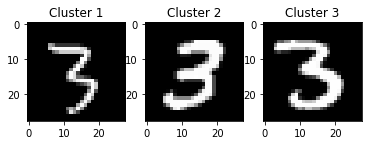

In [ ]:
x_0_c1, y_0_c1, x_0_c2, y_0_c2, x_0_c3, y_0_c3 = create_kmeans_clusters(data[0][0], data[0][1])
fig, axs = plt.subplots(1, 3)
axs[0].imshow(x_0_c1[0].reshape(28,28),cmap='gray')
axs[0].set_title('Cluster 1')
axs[1].imshow(x_0_c2[0].reshape(28,28),cmap='gray')
axs[1].set_title('Cluster 2')
axs[2].imshow(x_0_c3[0].reshape(28,28),cmap='gray')
axs[2].set_title('Cluster 3')

Text(0.5, 1.0, 'Cluster 3')

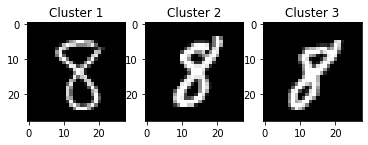

In [ ]:
x_6_c1, y_6_c1, x_6_c2, y_6_c2, x_6_c3, y_6_c3 = create_kmeans_clusters(data[1][0], data[1][1])
fig, axs = plt.subplots(1, 3)
axs[0].imshow(x_6_c1[0].reshape(28,28),cmap='gray')
axs[0].set_title('Cluster 1')
axs[1].imshow(x_6_c2[0].reshape(28,28),cmap='gray')
axs[1].set_title('Cluster 2')
axs[2].imshow(x_6_c3[0].reshape(28,28),cmap='gray')
axs[2].set_title('Cluster 3')

### Creation of individual train sets for the clients, global train set for the SVM model and a global test set containing the data from all the clusters



In [ ]:
X_train0_c1, X_test0_c1, y_train0_c1, y_test0_c1 = train_test_split(x_0_c1,y_0_c1,test_size=0.2)
X_train0_c2, X_test0_c2, y_train0_c2, y_test0_c2 = train_test_split(x_0_c2,y_0_c2,test_size=0.2)
X_train0_c3, X_test0_c3, y_train0_c3, y_test0_c3 = train_test_split(x_0_c3,y_0_c3,test_size=0.2)

In [ ]:
X_train6_c1, X_test6_c1, y_train6_c1, y_test6_c1 = train_test_split(x_6_c1,y_6_c1,test_size=0.2)
X_train6_c2, X_test6_c2, y_train6_c2, y_test6_c2 = train_test_split(x_6_c2,y_6_c2,test_size=0.2)
X_train6_c3, X_test6_c3, y_train6_c3, y_test6_c3 = train_test_split(x_6_c3,y_6_c3,test_size=0.2)

In [ ]:
X_test = np.concatenate((X_test0_c1,X_test0_c2,X_test0_c3,X_test6_c1,X_test6_c2,X_test6_c3),axis=0)
y_test = np.concatenate((y_test0_c1,y_test0_c2,y_test0_c3,y_test6_c1,y_test6_c2,y_test6_c3),axis=0)
y_test[ y_test == 3] = 0
y_test[ y_test == 8] = 1
print(X_test.shape)
print(y_test.shape)

(2795, 784)
(2795,)


In [ ]:
X_train_c1 = [X_train0_c1, X_train6_c1]
y_train_c1 = [y_train0_c1, y_train6_c1]
y_train_c1[0][:] = 0
y_train_c1[1][:] = 1
X_train_c2 = [X_train0_c2, X_train6_c2]
y_train_c2 = [y_train0_c2, y_train6_c2]
y_train_c2[0][:] = 0
y_train_c2[1][:] = 1
X_train_c3 = [X_train0_c3, X_train6_c3]
y_train_c3 = [y_train0_c3, y_train6_c3]
y_train_c3[0][:] = 0
y_train_c3[1][:] = 1

In [ ]:
X_train0_gl = np.concatenate((X_train_c1[0],X_train_c2[0],X_train_c3[0]),axis=0)
X_train1_gl = np.concatenate((X_train_c1[1],X_train_c2[1],X_train_c3[1]),axis=0)
y_train0_gl = np.concatenate((y_train_c1[0],y_train_c2[0],y_train_c3[0]),axis=0)
y_train1_gl = np.concatenate((y_train_c1[1],y_train_c2[1],y_train_c3[1]),axis=0)

### Federated learning model and SVM model training

#### Training the models without validation

In [ ]:
f_svm = Federated_SVM(n_clients = 3, val=False)
f_svm.create_clients([X_train_c1,X_train_c2,X_train_c3],[y_train_c1,y_train_c2,y_train_c3],X_test,y_test)
clients = copy.deepcopy(f_svm.clients)

In [ ]:
clf = SVM([X_train0_gl, X_train1_gl], [y_train0_gl, y_train1_gl], X_test, y_test, val=False)
clf.fit()
print(clf.accuracy())

97.13774597495528


In [ ]:
f_svm.fit(1,f_svm.average_aggregator)

global round 1
client 1 77.74597495527729
client 2 80.7871198568873
client 3 73.05903398926654
global test acc 94.16815742397138


#### Training the models with cross validation (balanced validation distribution)

In [ ]:
f_svm = Federated_SVM(n_clients = 3, val=True, val_type='cross_val', val_distribution='balanced')
f_svm.create_clients([X_train_c1,X_train_c2,X_train_c3],[y_train_c1,y_train_c2,y_train_c3],X_test,y_test)
clients = copy.deepcopy(f_svm.clients)

In [ ]:
clf = SVM([X_train0_gl, X_train1_gl], [y_train0_gl, y_train1_gl], X_test, y_test, val=True, val_type='cross_val', val_distribution='balanced')
clf.fit()
print(clf.accuracy())

97.20930232558139


In [ ]:
f_svm.fit(1,f_svm.average_aggregator)

global round 1
client 1 79.53488372093022
client 2 80.10733452593918
client 3 74.23971377459749
global test acc 94.63327370304114


#### Training the models with cross validation (unbalanced validation distribution)

In [ ]:
f_svm = Federated_SVM(n_clients = 3, val=True, val_type='cross_val', val_distribution='unbalanced')
f_svm.create_clients([X_train_c1,X_train_c2,X_train_c3],[y_train_c1,y_train_c2,y_train_c3],X_test,y_test)
clients = copy.deepcopy(f_svm.clients)

In [ ]:
clf = SVM([X_train0_gl, X_train1_gl], [y_train0_gl, y_train1_gl], X_test, y_test, val=True, val_type='cross_val', val_distribution='unbalanced')
clf.fit()
print(clf.accuracy())

96.95885509838999


In [ ]:
f_svm.fit(1,f_svm.average_aggregator)

global round 1
client 1 78.64042933810376
client 2 79.28443649373882
client 3 74.45438282647585
global test acc 95.02683363148479


#### Training the models with 5 fold cross validation (balanced validation distribution)

In [ ]:
f_svm = Federated_SVM(n_clients = 3, val=True, val_type='k_fold', val_distribution='balanced', k=5)
f_svm.create_clients([X_train_c1,X_train_c2,X_train_c3],[y_train_c1,y_train_c2,y_train_c3],X_test,y_test)
clients = copy.deepcopy(f_svm.clients)

In [ ]:
clf = SVM([X_train0_gl, X_train1_gl], [y_train0_gl, y_train1_gl], X_test, y_test, val=True, val_type='k_fold', val_distribution='balanced', k=5)
clf.fit()
print(clf.accuracy())

96.63685152057245
96.81574239713775
96.81574239713775
97.0304114490161
96.67262969588552
96.67262969588552


In [ ]:
f_svm.fit(1,f_svm.average_aggregator)

global round 1
78.53309481216458
79.32021466905188
79.53488372093022
80.0
77.49552772808586
client 1 77.3881932021467
79.67799642218247
80.17889087656529
82.00357781753131
80.35778175313058
80.64400715563507
client 2 79.67799642218247
74.13237924865832
73.66726296958855
73.48837209302326
73.38103756708408
73.23792486583184
client 3 74.13237924865832
global test acc 95.2772808586762


#### Training the models with 5 fold cross validation (unbalanced validation distribution)

In [ ]:
f_svm = Federated_SVM(n_clients = 3, val=True, val_type='k_fold', val_distribution='unbalanced', k=5)
f_svm.create_clients([X_train_c1,X_train_c2,X_train_c3],[y_train_c1,y_train_c2,y_train_c3],X_test,y_test)
clients = copy.deepcopy(f_svm.clients)

In [ ]:
clf = SVM([X_train0_gl, X_train1_gl], [y_train0_gl, y_train1_gl], X_test, y_test, val=True, val_type='k_fold', val_distribution='unbalanced', k=5)
clf.fit()
print(clf.accuracy())

97.31663685152057
96.99463327370304
96.63685152057245
97.0304114490161
96.92307692307692
96.56529516994632


In [ ]:
f_svm.fit(1,f_svm.average_aggregator)

global round 1
80.60822898032201
79.35599284436495
79.06976744186046
81.25223613595706
78.4257602862254
client 1 80.60822898032201
80.32200357781754
80.89445438282648
79.85688729874776
79.92844364937388
80.82289803220036
client 2 80.25044722719142
72.98747763864043
73.55992844364937
73.41681574239713
73.34525939177102
73.95348837209302
client 3 72.98747763864043
global test acc 94.77638640429338
